## Comparison of EFAS forecast and the local water gauge during January 2018 floods in Cologne

#### Introduction
On January 2018, the city of Cologne has seen one of the largest floods in recent years. The flood peaked at 8th of January according to *Kölner Pegel*, the local water gauge at the city center; with a recorded value of **8.71 m**, where the typical average runs around 2-3 meters. [According to StEB](https://steb-koeln.de/hochwasser-und-ueberflutungsschutz/hochwasser/hochwassermanagement/hochwassermanagement.jsp) (Cologne wastewater treatment company), the waterfront of Cologne old town is expected to be flooded starting from water gauge of **8.10 m**. The picture below is taken on 8th of January, showing the part of the riverbank along the oldtown of Cologne. It also shows the Pegel itself partially flooded at the center left, in front of the trees. Detailed information about the properties and history of the Kölner Pegel can be found [here](https://undine.bafg.de/rhein/pegel/rhein_pegel_koeln.html).

<figure style="text-align:center;">
  <img src="images/jan18.jpg" 
       alt="Rhine flood Cologne 2018" 
       width="850" 
       style="border:2px solid black;">
  <figcaption style="font-style:italic; color:gray; margin-top:5px;">
    Figure 1. Rhine flood in Cologne's oldtown, 8 January 2018 © Superbass / CC-BY-SA-4.0 (via Wikimedia Commons) (modified)
  </figcaption>
</figure>


#### Purpose and workflow
This notebook examines river discharge of Rhein in Cologne during the two-week period in January, centered at 8th January. The observed data from in-situ Pegel is compared to the forecast by [EFAS (European Flood Awareness System)](https://european-flood.emergency.copernicus.eu/en) in order to study whether the forecast was accurate. First the Pegel data will be examined. Then the forecasting data will be processed. Finally both datasets will be compared and analyzed. In doing this study, I am  inspired from local case studies shared [here](https://confluence.ecmwf.int/display/CEMS/5.3+Share+a+Case+Study). 

#### Disclaimer

Please note that this is my first ever study of a hydrology topic and such type of datasets and I claim no expertise. I learned lot of things on these topics while working on this notebook such as LISFLOSS model and Ratio curves. There might be technical mistakes in calculations or in the interpretation of outcomes. I appreciate any feedback, comments or corrections greatly!

#### Datasets
- Water gauge dataset is available [here](https://www.wasserstaende.de/gast/stammdaten?pegelnr=2730010). Discharge and height datasets are used here for the period of 1-15 January 2018.
- The EFAS forecast datasets are available upon registration to the system, a download request needs to be made after selecting the dataset of choice. The datasets are gridded. So in order to make sure area of interest is included in the downloaded datasets, the bounds of regions are selected such that they extend 5 kilometers from the Kölner Pegel in all four directions. See also Fig.3 and Fig4 and their descriptions.
  - Reforecasted dataset: This dataset answers the question: "What would the prediction have been, if we had our current forecasting model at a past instance?". So this is supposed to be giving the best possible forecast within the limits and quality of available information at the time of interest.
    - Dataset: Joint Research Center, Copernicus Emergency Management Service (2019): Reforecasts of river discharge and related data by the European Flood Awareness System. Early Warning Data Store (EWDS). DOI: 10.24381/cds.c83f560f (Accessed on 26-08-2025) 
  - Historical dataset: This dataset uses the forecasting model to get the output values (river discharge rate etc.) but its inputs are actual realized meteorological data, in contrast to forecasts.
    - Dataset: Joint Research Center, Copernicus Emergency Management Service (2019): River discharge and related historical data from the European Flood Awareness System. Early Warning Data Store (EWDS). DOI: 10.24381/cds.e3458969 (Accessed on 24-08-2025)  

<figure style="text-align:center;">
  <img src="images/rheincatchment.jpg" 
       alt="Rhine flood Cologne 2018" 
       width="500" 
       style="border:2px solid black;">
  <figcaption style="font-style:italic; color:gray; margin-top:5px;">
    Figure 2. Basin of river Rhein © WWasser / CC-BY-SA-4.0 (via Wikimedia Commons)
  </figcaption>
</figure>


### **Observations from Kölner Pegel dataset**

Here, we first study the water height and water discharge datasets recorded by the Pegel.

In [1]:
# Read-in the water level dataset and check the content
import pandas as pd
import matplotlib.pyplot as plt

W_path = "/Users/oncel/Downloads/pegelonline-kln-W-20180101-20180115/pegelonline-kln-W-20180101-20180115.csv"

dfW = pd.read_csv(W_path, sep=";", parse_dates=["timestamp"])

print(dfW.head())

            timestamp  value
0 2018-01-01 00:00:00    470
1 2018-01-01 00:15:00    471
2 2018-01-01 00:30:00    472
3 2018-01-01 00:45:00    473
4 2018-01-01 01:00:00    474


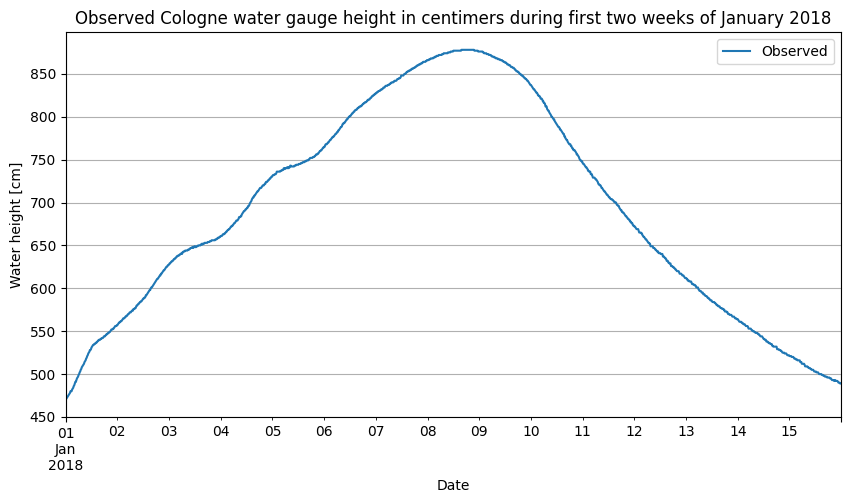

In [2]:
# Plot the observed water level

dfW.plot(x="timestamp", y="value", figsize=(10,5), grid=True, 
         title="Observed Cologne water gauge height in centimers during first two weeks of January 2018", label="Observed")
plt.xlabel("Date")
plt.ylabel("Water height [cm]")
plt.show()


It can be seen that, the water height plot is consistent with the reports saying the flooding peaked on 8th of January with a recorded level of 8.71m. This is a good check to see we are working with the right dataset

In [83]:
# Read-in the water discharge dataset and check the content
Q_path = "/Users/oncel/Downloads/pegelonline-kln-W-20180101-20180115/pegelonline-kln-Q-20180101-20180115.csv"

dfQ = pd.read_csv(Q_path, sep=";", parse_dates=["timestamp"])

print(dfQ.head())

            timestamp  value
0 2018-01-01 00:00:00   3199
1 2018-01-01 00:15:00   3207
2 2018-01-01 00:30:00   3216
3 2018-01-01 00:45:00   3224
4 2018-01-01 01:00:00   3233


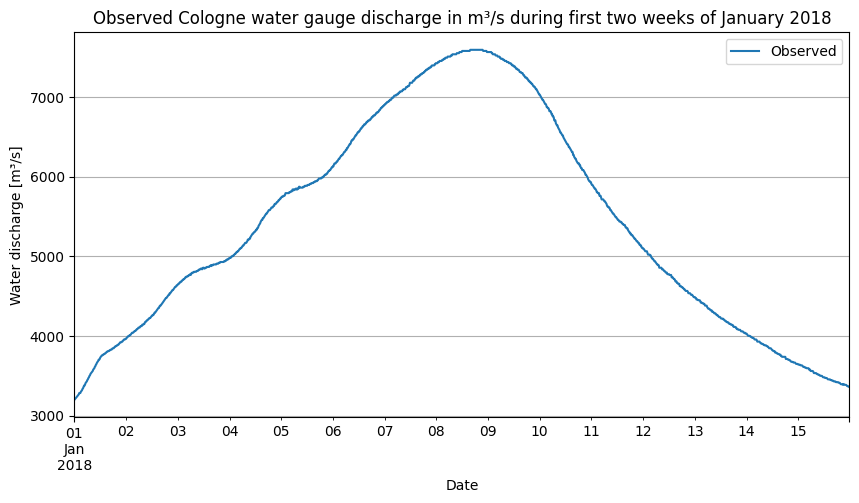

In [4]:
# Plot the observed water discharge
dfQ.plot(x="timestamp", y="value", figsize=(10,5), grid=True,
         title="Observed Cologne water gauge discharge in m³/s during first two weeks of January 2018", label="Observed")
plt.xlabel("Date")
plt.ylabel("Water discharge [m³/s]")
plt.show()

**The river discharge is very strongly correlated with the water height. In fact, if we compute the Pearson correlation coefficient we can see that it is > 99%.**

In [5]:
# Pearson correlation coefficient
corr = dfW["value"].corr(dfQ["value"], method="pearson")
print("Correlation coefficient:", corr)

Correlation coefficient: 0.9978177925341193


This relationship between discharge and water level is expected and scientifically described with a power-law-following Rating Curve:
$$ Q = a \, (h - h_{0})^{b} $$
where

$Q$: discharge $\;\; [\tfrac{m^{3}}{s}]$  
$h$: water level (stage) [m]  
$h_{0}$: threshold stage (zero-flow level) [m]  
$a,b$: empirical coefficients (dimensionless) 

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Observed pegel data
height_cm = np.array(dfW["value"]) # W
discharge = np.array(dfQ["value"]) # Q

# Convert cm → m
height_m = height_cm / 100.0

# Define rating curve function
def rating_curve(h, a, h0, b):
    return a * np.maximum(h - h0, 0)**b

# Initial guesses and bounds
params, cov = curve_fit(
    rating_curve,
    height_m,
    discharge,
    p0=[1000, 3.5, 2],              
    bounds=([0, 0, 0.5], [1e5, 6, 5])  
)

a, h0, b = params
print(f"Fitted rating curve: Q = {a:.2f} * (h - {h0:.2f})^{b:.2f}")
print(f"Thus, a = {a:.2f}, b= {b:.2f} and h_0 = {h0:.2f}")

Fitted rating curve: Q = 344.32 * (h - 0.00)^1.42
Thus, a = 344.32, b= 1.42 and h_0 = 0.00


**Amount of water discharge needed for oldtown of Cologne to be flooded can then be found by plugging in h = 8.1 which is about 
Q = 6715 m³/s.**

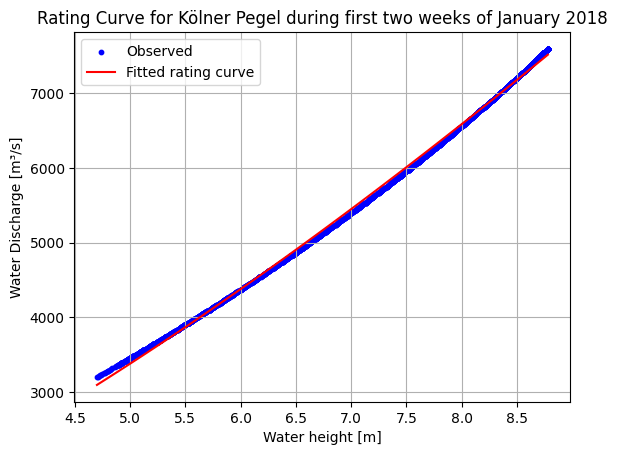

In [7]:
# Plot the rating curve
h_fit = np.linspace(min(height_m), max(height_m), 100)
q_fit = rating_curve(h_fit, *params)

plt.scatter(height_m, discharge,s=10, color="blue", label="Observed")
plt.plot(h_fit, q_fit, color="red", label="Fitted rating curve")
plt.xlabel("Water height [m]")
plt.ylabel("Water Discharge [m³/s]")
plt.title("Rating Curve for Kölner Pegel during first two weeks of January 2018")
plt.legend()
plt.grid(True)
plt.show()

b > 1 indicates that the **flow accelerates with the water height**. This is expected for large rivers such as Rhein as discharge is computed by

Q = (Cross-sectional flow area) X (Mean velocity) 

and more depth means more cross-sectional area and also larger velocity. The velocity increase is not as intuitional as cross-sectional area. It can be thought of as originating from a reduction in fraction of water volume getting slowed by the frictional forces of riverbed and edges. More water means, relatively less fraction of total water volume is in contact with such forces. Thus average velocity increases. For details see Manning's Equation.

### **Studying the EFAS datasets**

Our dataset here is gridded. In order the compare the forecast to the in-situ pegel observation, we need to first find the grid point closest to actual location of observations. For this we take the coordinates of Kölner Pegel as the reference point.

In [8]:
import os
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Coordinates of Kölner Pegel
cologne_lat, cologne_lon = 50.9369, 6.9632

It should be noted that there are two types of *reporting points* in the gridded flood forecasting map system:
- EFAS Fixed Reporting Points: This point correspond exactly to the real location of a river gauge. It will be used in the post-processing, for calibration and comparison of what the gauge has measured and the forecast predicted. Area of the closest grid element and the coordinate of the Pegel itself is shown on the map from the EFAS on the figure below on the left.
- LISFLOOD Fixed Reporting Points: This point does not correspond exactly to a real location where a river gauge is present. But it is defined in the grid framework such that its dynamics will be representative of the nearest river gauge. The virtual reporting point corresponding to the Kölner Pegel is shown as a gray colored square on the map from GloFAS below right.

<table>
<tr>
  <td align="center">
    <img src="images/efas_point.png" width="400"><br>
    Figure 3. EFAS Fixed Reporting Point for Cologne river gauge (screen shot from EFAS, https://european-flood.emergency.copernicus.eu/efas_frontend/#/home)
  </td>
  <td align="center">
    <img src="images/glofas_point.png" width="400"><br>
    Figure 4. LISFLOOD Fixed Reporting Point for Cologne river gauge (screen shot from GLOFAS, https://global-flood.emergency.copernicus.eu/glofas-forecasting/)
  </td>
</tr>
</table>

#### **Reforecasted dataset**

The dataset has two types of values: control and ensemble, where control represent the mean and the ensemble (consisting of varied forecasts from slighly shifted initial values) is used to estimate the uncertainties.

In [87]:
# Read-in the dataset separate the two data formats
import xarray as xr

rfc_file = "/Users/oncel/Downloads/pegelonline-kln-W-20180101-20180115/2018JanKoeln_reforecasted.grib"

# Load the ensemble and control separately
ds_cf = xr.open_dataset(
    rfc_file,
    engine="cfgrib",
    filter_by_keys={"dataType": "cf"}
)

ds_pf = xr.open_dataset(
    rfc_file,
    engine="cfgrib",
    filter_by_keys={"dataType": "pf"}
)

# Some more modifications are needed to get the program not complaining about the dataset structure:

# Give control forecast a dummy "number" dimension
ds_cf = ds_cf.expand_dims(number=[0])

# Add dataType coordinate
ds_cf = ds_cf.assign_coords(dataType="cf")
ds_pf = ds_pf.assign_coords(dataType="pf")

# Concatenate along dataType
ds = xr.concat([ds_cf, ds_pf], dim="dataType")

/opt/homebrew/Cellar/jupyterlab/4.3.6/libexec/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode the variable 'step' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/opt/homebrew/Cellar/jupyterlab/4.3.6/libexec/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode the variable 'step' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by def

In [88]:
# Find the closest grid point in the dataset to the reference coordinate
import numpy as np
import matplotlib.pyplot as plt

# Find nearest grid cell
abs_lat = np.abs(ds.latitude - cologne_lat)
abs_lon = np.abs(ds.longitude - cologne_lon)
dist = abs_lat + abs_lon
iy, ix = np.unravel_index(dist.argmin(), dist.shape)

lat_nearest = float(ds.latitude[iy])
lon_nearest = float(ds.longitude[ix])
print("Nearest grid point:", lat_nearest, lon_nearest)

ens_point = ds_pf.isel(latitude=iy, longitude=ix)
ctrl_point = ds_cf.isel(latitude=iy, longitude=ix)

# Find nearest grid point
#ens_point  = ens.sel(latitude=cologne_lat, longitude=cologne_lon, method="nearest")
#ctrl_point = ctrl.sel(latitude=cologne_lat, longitude=cologne_lon, method="nearest")



Nearest grid point: 50.941666000000005 6.958332999999999


This coordinate corresponds to the northern transcept of the Cologne Cathedral! This seems to be matching with the center of the pink grid box of Figure 3 above.


In [89]:
# Create the control and ensemble sets
ens_point  = ens_point.sel(time=slice("2018-01-01", "2018-01-15"))
ctrl_point = ctrl_point.sel(time=slice("2018-01-01", "2018-01-15"))

# Control forecast = ensemble member 0
ctrl_point_ctrl = ctrl_point["dis06"].isel(number=0)  # pick variable + ensemble member
x = ctrl_point_ctrl.time.values
ctrl_y = ctrl_point_ctrl.to_numpy().flatten()             # ensure 1D
print('ctrl (0):',ctrl_y)

# Convert directly to DataFrame (xarray does this neatly)
df = ens_point["dis06"].to_pandas()
df = df.sort_index()   # ensures number order
print(df)

ctrl (0): [2847.3662 4300.5537 6869.166  4202.448  2691.3882]
time     2018-01-01   2018-01-04   2018-01-08   2018-01-11   2018-01-15
number                                                                 
1       2847.377930  4300.549805  6869.167969  4202.432129  2691.384277
2       2847.368652  4301.213867  6869.164551  4202.513672  2691.389160
3       2847.367676  4300.849121  6869.164062  4202.433594  2691.383789
4       2847.379883  4300.543457  6869.170410  4202.448242  2691.390137
5       2847.355469  4300.539551  6869.162598  4202.473633  2691.386230
6       2847.373047  4300.552246  6869.168457  4202.446289  2691.388672
7       2847.368164  4300.621094  6869.166992  4202.431152  2691.388184
8       2847.356934  4300.539551  6869.164551  4202.447754  2691.387695
9       2847.352051  4300.536621  6869.165039  4202.453125  2691.389160
10      2847.381348  4300.564453  6869.166504  4202.453613  2691.385742


Despite our wish to put a nice error band around the central value, the **variations are extremely small** (not sure if that is expected behavior) and not visible on the plots. Thus, we drop working with ensemble and continue with the central value only.

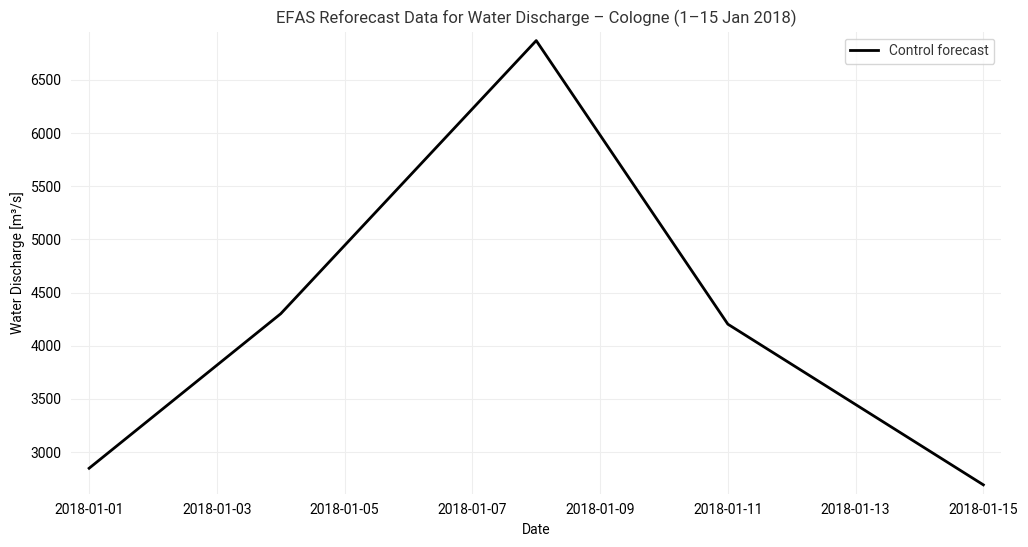

In [53]:
# Plot
plt.figure(figsize=(12,6))
plt.plot(x, ctrl_y, color="black", lw=2, zorder=2, label="Control forecast")
plt.title("EFAS Reforecast Data for Water Discharge – Cologne (1–15 Jan 2018)")
plt.ylabel("Water Discharge [m³/s]")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.show()

Some observations:
- The reforecasted data qualitatively captures the hydrodynamics of the flood.
- **The peak discharge is underestimated.**
- There are only few data points covering this period, difficult to assess in details.
- Ensemble variations are very close to actual control value, that's why a band around the central value cannot be seen.

#### **Historical dataset**

In [54]:
efas_file = "/Users/oncel/Downloads/pegelonline-kln-W-20180101-20180115/2018JanKoeln.grib"
efas_data = xr.open_dataset(efas_file, engine="cfgrib")

/opt/homebrew/Cellar/jupyterlab/4.3.6/libexec/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode the variable 'step' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


In [55]:
# Open the dataset
ds = xr.open_dataset(efas_file)

# Find nearest grid cell
abs_lat = np.abs(ds.latitude - cologne_lat)
abs_lon = np.abs(ds.longitude - cologne_lon)
dist = abs_lat + abs_lon
iy, ix = np.unravel_index(dist.argmin(), dist.shape)

lat_nearest = float(ds.latitude[iy])
lon_nearest = float(ds.longitude[ix])
print("Nearest grid point:", lat_nearest, lon_nearest)

# Extract discharge time serie (6h granularity)
ts = ds["dis06"].isel(latitude=iy, longitude=ix)

Nearest grid point: 50.941666000000005 6.958332999999999


/opt/homebrew/Cellar/jupyterlab/4.3.6/libexec/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode the variable 'step' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


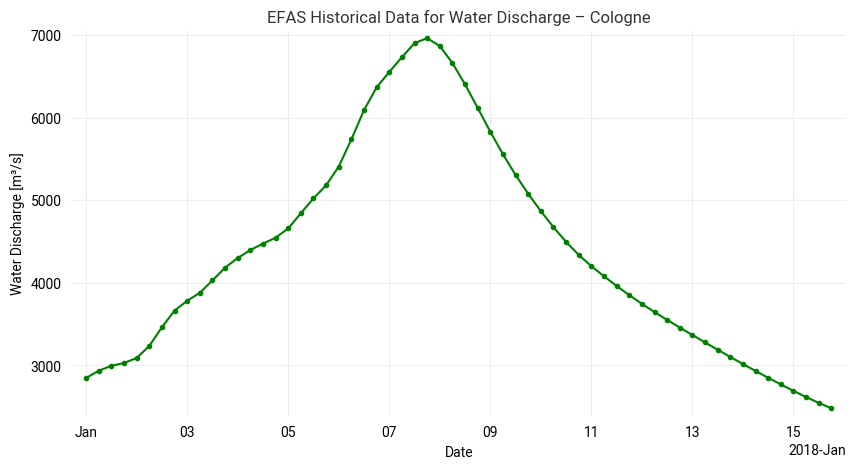

In [82]:
# Plot
plt.figure(figsize=(10,5))
ts.plot(marker=".", color="green")
plt.title(f"EFAS Historical Data for Water Discharge – Cologne")
plt.ylabel("Water Discharge [m³/s]")
plt.xlabel("Date")
plt.grid(True)
plt.show()

- The qualitative behaviour is similar
- 24h/6h = 4 times more data points per day creates a smoother shape

### **Comparison of datasets**

#### **Qualitative**

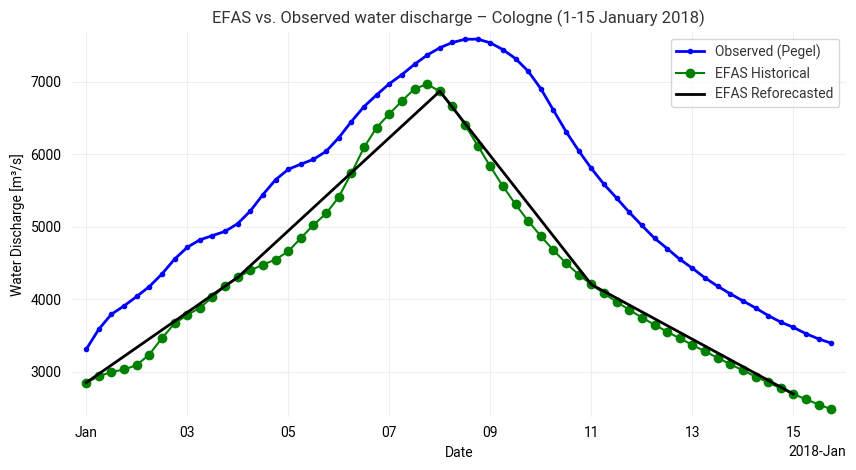

In [80]:
# Pegel data cleanup
# If "timestamp" is still a column, parse carefully:
if "timestamp" in dfQ.columns:
    # Try parsing as datetime strings, or seconds since epoch if numeric
    dfQ["timestamp"] = pd.to_datetime(
        dfQ["timestamp"], errors="coerce", infer_datetime_format=True
    )
    dfQ = dfQ.set_index("timestamp")

# Ensure index is datetime
dfQ.index = pd.to_datetime(dfQ.index, errors="coerce")

# Drop any NaT (unparsable) and any 1970 ghosts
dfQ = dfQ[ (dfQ.index >= "2018-01-01") & (dfQ.index <= "2018-01-31") ]

# 15 min data points -> 6 hour mean data points (to match granularity of dataset)
dfQ_resampled = dfQ.resample("6h").mean()

# Control forecast cleanup
x_fixed = pd.to_datetime(ctrl_point_ctrl.time.values).to_pydatetime()
ctrl_y  = ctrl_point_ctrl.values

# Plot
plt.figure(figsize=(10,5))
ax = plt.gca()

# Observed Pegel
ax.plot(dfQ_resampled.index, dfQ_resampled["value"],
        color="blue", lw=2, marker="o", markersize=3,
        label="Observed (Pegel)")

# EFAS forecast (time series DataArray)
ts.plot(marker="o", ax=ax, label="EFAS Historical", color="green")

# Control forecast (fixed x-axis)
ax.plot(x_fixed, ctrl_y, color="black", lw=2, label="EFAS Reforecasted")

# Styling
plt.title("EFAS vs. Observed water discharge – Cologne (1-15 January 2018)")
plt.ylabel("Water Discharge [m³/s]")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.show()

Qualitatively, it can be clearly seen that EFAS gets the shape but not the normalization of the flood dynamics. That is, **the model underestimates the river discharge at all times.**

Let's try to quantify the comparison next.

#### **Quantitative**

An important issue that needs to be addressed here is that in a quantitative study (s.a. correlation) we need to account for differences in the granularity of the datasets. Reforecasted dataset does not have values for each day, and for the days it has, it is only one value per day. Whereas observed Pegel dataset has values for each day with a frequency of 15 minutes within the day.

Control forecast:
  RMSE = 951.75, R² = 0.61, Corr = 0.97, Bias = -864.01
Ensemble mean forecast (ts):
  RMSE = 1130.30, R² = 0.30, Corr = 0.95, Bias = -1047.08


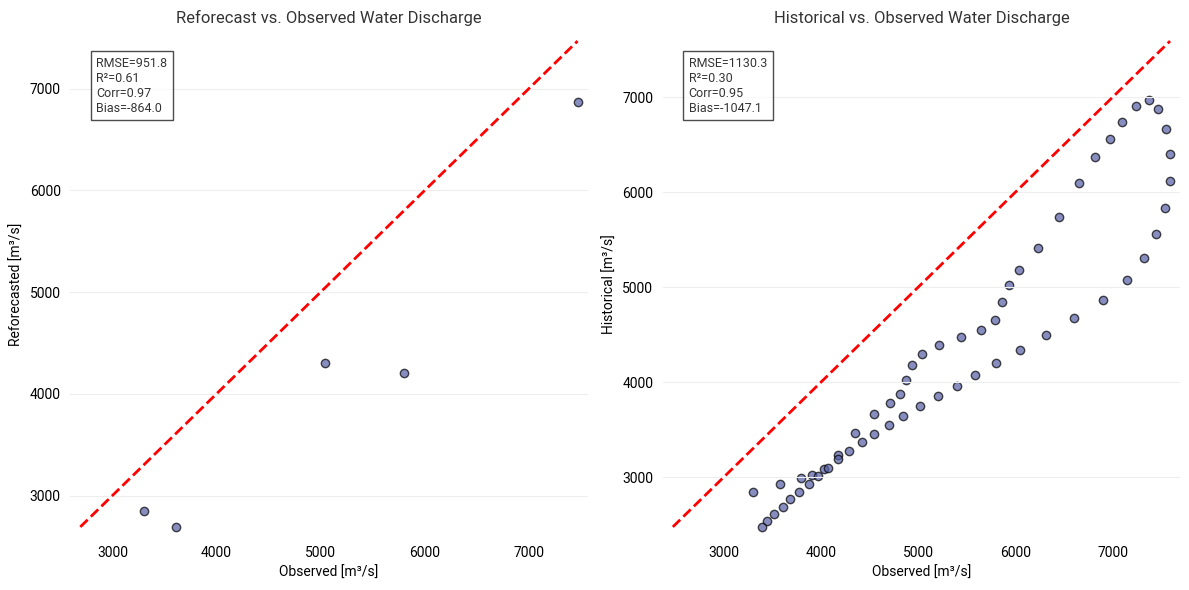

In [62]:
from sklearn.metrics import mean_squared_error, r2_score
# Align observed with control forecast
df_obs = dfQ_resampled["value"]   # observed Pegel (6h mean)

# Control series
ctrl_series = pd.Series(ctrl_y, index=pd.to_datetime(x))
obs_ctrl, ctrl_aligned = df_obs.align(ctrl_series, join="inner")

# Ensemble mean series (ts already plotted earlier)
ts_series = pd.Series(ts.values, index=pd.to_datetime(ts.time.values))
obs_ts, ts_aligned = df_obs.align(ts_series, join="inner")

# Metrics function
def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    corr = y_true.corr(y_pred)
    bias = (y_pred - y_true).mean()
    return rmse, r2, corr, bias

# Control metrics
rmse_c, r2_c, corr_c, bias_c = compute_metrics(obs_ctrl, ctrl_aligned)

# Ensemble mean metrics
rmse_t, r2_t, corr_t, bias_t = compute_metrics(obs_ts, ts_aligned)

print("Control forecast:")
print(f"  RMSE = {rmse_c:.2f}, R² = {r2_c:.2f}, Corr = {corr_c:.2f}, Bias = {bias_c:.2f}")
print("Ensemble mean forecast (ts):")
print(f"  RMSE = {rmse_t:.2f}, R² = {r2_t:.2f}, Corr = {corr_t:.2f}, Bias = {bias_t:.2f}")

# Scatter plots
plt.figure(figsize=(12,6))

# Control scatter
plt.subplot(1,2,1)
plt.scatter(obs_ctrl, ctrl_aligned, alpha=0.7, edgecolor="k")
lims = [min(obs_ctrl.min(), ctrl_aligned.min()), max(obs_ctrl.max(), ctrl_aligned.max())]
plt.plot(lims, lims, "r--", lw=2)
plt.title("Reforecast vs. Observed Water Discharge")
plt.xlabel("Observed [m³/s]")
plt.ylabel("Reforecasted [m³/s]")
plt.text(0.05, 0.95, f"RMSE={rmse_c:.1f}\nR²={r2_c:.2f}\nCorr={corr_c:.2f}\nBias={bias_c:.1f}",
         transform=plt.gca().transAxes, va="top", ha="left", fontsize=9,
         bbox=dict(facecolor="white", alpha=0.7))

# Ensemble mean scatter
plt.subplot(1,2,2)
plt.scatter(obs_ts, ts_aligned, alpha=0.7, edgecolor="k")
lims = [min(obs_ts.min(), ts_aligned.min()), max(obs_ts.max(), ts_aligned.max())]
plt.plot(lims, lims, "r--", lw=2)
plt.title("Historical vs. Observed Water Discharge")
plt.xlabel("Observed [m³/s]")
plt.ylabel("Historical [m³/s]")
plt.text(0.05, 0.95, f"RMSE={rmse_t:.1f}\nR²={r2_t:.2f}\nCorr={corr_t:.2f}\nBias={bias_t:.1f}",
         transform=plt.gca().transAxes, va="top", ha="left", fontsize=9,
         bbox=dict(facecolor="white", alpha=0.7))

plt.tight_layout()
plt.show()

Quantitative Findings:
- Models have high correlation with the observation.
- Models underestimate the water discharge at all times.
  
Although the reforecasted dataset has less discrepancy, it should be noted that the reforecasted dataset lacks the points for where historical dataset has the worst forecast i.e. 4-6 January period. Thus, the increased performance seems  artificial, as points actually present in both forecasts indicate similar trends. We can attempt at a recalculation by using only the points available for reforecasted data

                   ctrl         hist
2018-01-01  2847.366211  2847.586914
2018-01-04  4300.553711  4300.485840
2018-01-08  6869.166016  6869.141113
2018-01-11  4202.448242  4202.387207
2018-01-15  2691.388184  2691.355469
Control forecast:
  RMSE = 947.74, R² = 0.59, Corr = 0.99, Bias = -922.04
Ensemble mean forecast (ts):
  RMSE = 947.75, R² = 0.59, Corr = 0.99, Bias = -922.03


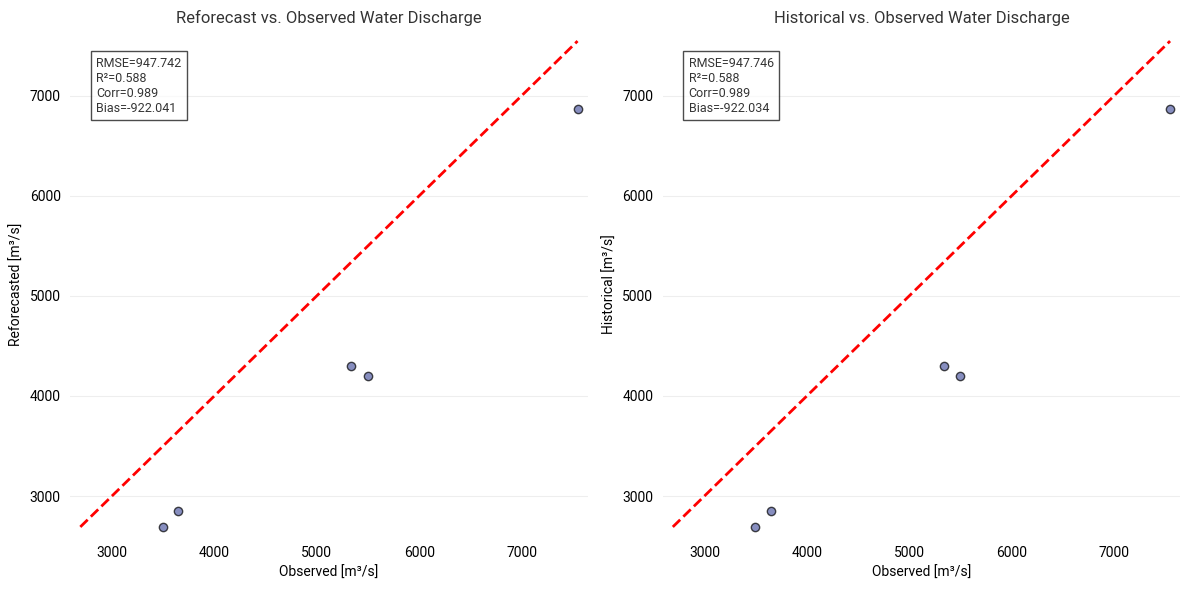

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Observed (6h -> daily mean)
df_obs_daily = df_obs.resample("1D").mean()

# Build aligned DataFrame with all three series
df_all = pd.concat([
    df_obs_daily.rename("obs"),
    pd.Series(ctrl_y, index=pd.to_datetime(x), name="ctrl"),
    pd.Series(ts.values, index=pd.to_datetime(ts.time.values), name="hist")
], axis=1)

# Keep only rows where all three are present
df_all = df_all.dropna()

# Extract aligned series
obs_ctrl = df_all["obs"]
ctrl_aligned = df_all["ctrl"]
ts_aligned = df_all["hist"]
# Keep only the columns you want
df_print = df_all[["ctrl", "hist"]]

# Print nicely
print(df_print)

# Metrics function
def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    corr = y_true.corr(y_pred)
    bias = (y_pred - y_true).mean()
    return rmse, r2, corr, bias

# Control metrics
rmse_c, r2_c, corr_c, bias_c = compute_metrics(obs_ctrl, ctrl_aligned)

# Historical mean metrics
rmse_t, r2_t, corr_t, bias_t = compute_metrics(obs_ctrl, ts_aligned)

print("Control forecast:")
print(f"  RMSE = {rmse_c:.2f}, R² = {r2_c:.2f}, Corr = {corr_c:.2f}, Bias = {bias_c:.2f}")
print("Ensemble mean forecast (ts):")
print(f"  RMSE = {rmse_t:.2f}, R² = {r2_t:.2f}, Corr = {corr_t:.2f}, Bias = {bias_t:.2f}")

# Scatter plots
plt.figure(figsize=(12,6))

# Control scatter
plt.subplot(1,2,1)
plt.scatter(obs_ctrl, ctrl_aligned, alpha=0.7, edgecolor="k")
lims = [min(obs_ctrl.min(), ctrl_aligned.min()), max(obs_ctrl.max(), ctrl_aligned.max())]
plt.plot(lims, lims, "r--", lw=2)
plt.title("Reforecast vs. Observed Water Discharge")
plt.xlabel("Observed [m³/s]")
plt.ylabel("Reforecasted [m³/s]")
plt.text(0.05, 0.95,
         f"RMSE={rmse_c:.3f}\nR²={r2_c:.3f}\nCorr={corr_c:.3f}\nBias={bias_c:.3f}",
         transform=plt.gca().transAxes, va="top", ha="left", fontsize=9,
         bbox=dict(facecolor="white", alpha=0.7))

# Historical scatter
plt.subplot(1,2,2)
plt.scatter(obs_ctrl, ts_aligned, alpha=0.7, edgecolor="k")
lims = [min(obs_ctrl.min(), ts_aligned.min()), max(obs_ctrl.max(), ts_aligned.max())]
plt.plot(lims, lims, "r--", lw=2)
plt.title("Historical vs. Observed Water Discharge")
plt.xlabel("Observed [m³/s]")
plt.ylabel("Historical [m³/s]")
plt.text(0.05, 0.95,
         f"RMSE={rmse_t:.3f}\nR²={r2_t:.3f}\nCorr={corr_t:.3f}\nBias={bias_t:.3f}",
         transform=plt.gca().transAxes, va="top", ha="left", fontsize=9,
         bbox=dict(facecolor="white", alpha=0.7))

plt.tight_layout()
plt.show()

Our previous suspicion is confirmed, that we see here that actually historical dataset has very similar values for the same dates that exist in the reforecasted dataset. Thus, the performance metrics became almost exactly the same 

### **Interpretation of results**

#### **Interpretation I: Comparison with official long-time findings of EFAS regarding forecasting discharge at Kölner Pegel**

On EFAS webpage, there are post-processed calibration information regarding river gauges. In Figure 5, the summary table for Cologne is shown. Unfortunately, gauge-specific information is only available starting from 2019, preventing us from looking at the hydrological performance on the days of 2018 flood. The metrics here are computed using data between 2013-2021. So it covers a much more longer duration than our limited time series analysis here.

<figure style="text-align:center;">
  <img src="images/EFAS_cologne.png" 
       alt="Rhine flood Cologne 2018" 
       width="1200" 
       style="border:2px solid black;">
  <figcaption style="font-style:italic; color:gray; margin-top:5px;">
    Figure 5. Hydrological skills of Cologne river gauge (screen shot from EFAS webpage)
  </figcaption>
</figure>

Let's try to compute some of the metrics used by EFAS for our case:

In [79]:
df_obs=df_all["obs"]
df_sim=df_all["ctrl"]
df = pd.merge(df_obs, df_sim, left_index=True, right_index=True, how="inner")
Qobs = df["obs"].values
Qsim = df["ctrl"].values

mask = ~np.isnan(Qobs) & ~np.isnan(Qsim)
Qobs, Qsim = Qobs[mask], Qsim[mask]

Qobs = df_obs.values
Qsim = df_sim.values

# Pearson Correlation
correlation = np.corrcoef(Qobs, Qsim)[0, 1]

# Nash-Sutcliffe Efficiency (NSE)
NSE = 1 - np.sum((Qobs - Qsim)**2) / np.sum((Qobs - np.mean(Qobs))**2)

# Kling-Gupta Efficiency (KGE)
r = correlation
beta = np.mean(Qsim) / np.mean(Qobs)  # bias ratio
gamma = (np.std(Qsim) / np.mean(Qsim)) / (np.std(Qobs) / np.mean(Qobs))  # variability ratio
KGE = 1 - np.sqrt((r - 1)**2 + (beta - 1)**2 + (gamma - 1)**2)
bias_percent = (np.mean(Qsim) - np.mean(Qobs)) / np.mean(Qobs) * 100
print(f"Bias = {bias_percent:.2f}%")
print(f"Correlation: {correlation:.3f}")
print(f"NSE: {NSE:.3f}")
print(f"KGE: {KGE:.3f}")

Bias = -18.06%
Correlation: 0.989
NSE: 0.588
KGE: 0.699


In [65]:
def kge_components(Qobs, Qsim):
    """
    Compute KGE and its components: correlation (r),
    bias ratio (beta), variability ratio (gamma).
    """
    # remove NaNs
    mask = ~np.isnan(Qobs) & ~np.isnan(Qsim)
    Qobs, Qsim = Qobs[mask], Qsim[mask]

    # Correlation
    r = np.corrcoef(Qobs, Qsim)[0, 1]

    # Bias ratio (mean simulated / mean observed)
    beta = np.mean(Qsim) / np.mean(Qobs)

    # Variability ratio (CVsim / CVobs)
    cv_obs = np.std(Qobs, ddof=1) / np.mean(Qobs)
    cv_sim = np.std(Qsim, ddof=1) / np.mean(Qsim)
    gamma = cv_sim / cv_obs

    # KGE
    KGE = 1 - np.sqrt((r - 1)**2 + (beta - 1)**2 + (gamma - 1)**2)

    return KGE, r, beta, gamma

In [66]:
KGE, r, beta, gamma = kge_components(Qobs, Qsim)

print(f"KGE    = {KGE:.3f}")
print(f"r      = {r:.3f}  (correlation)")
print(f"beta   = {beta:.3f}  (bias ratio)")
print(f"gamma  = {gamma:.3f}  (variability ratio)")

KGE    = 0.699
r      = 0.989  (correlation)
beta   = 0.819  (bias ratio)
gamma  = 1.240  (variability ratio)




| Metric            | This Study                            | EFAS Calibration                     | Difference from EFAS (%) | Comments                                                                                                                         |
| ----------------- | ---------------------------------------------- | ------------------------------------ | -------------- | -------------------------------------------------------------------------------------------------------------------------------- |
| **Time interval** | 1–15 Jan 2018 | 2013-11-17 → 2021-12-31 | **−99.5%**             | The study covers only 0.5% of the time period covered by EFAS                                     |
| **Correlation**   | 0.98                                           | 0.90                                 | **+8.9%**      | Both being very high, our study shows better correlation compared to EFAS data |
| **Bias**          | 0.82                                           | 0.97                                 | **−15.5%**     | Our study shows significantly larger bias compared to EFAS' findings                                              |
| **NSE**           | 0.58                                           | 0.80                                 | **−27.5%**     | The largest difference is measured here. This makes sense as NSE is a parameter based on mean flow, whereas we studied a time period of a flooding event in which flow rates are significant higher compared to the mean.                         |
| **KGE**           | 0.69                                           | 0.89                                 | **−22.5%**     | KGE is a function of correlation, bias and variability. In our case correlation is high, bias is low and variability is 24% higher.  Latter two parameters decrease the KGE, but since correlation is matching well and divergences are not too large, we end up with a poorer but not terrible KGE.                        |


EFAS [webpage](https://confluence.ecmwf.int/display/CEMS/EFAS+Reporting+Points) informs its users that hydrographic post-processed parameters are expected to have lower accuracy during extreme events. This is also what we saw in our investigation of parameters used by EFAS in our study here. The divergences in the results thus can be attributed to the short duration; and more importantly to the extreme nature of the hydrological activity that took place during this   period.

#### **Interpretation II: Would there be real-life consquences of water discharge underestimation?**
An interesting question is, whether the underestimated water discharge forecast would have misled the authorities in an hypothetical scenario. Remembering almost full correlation between the water discharge and height, let's check if the underestimated discharge numbers still predict the flooding of the oldtown of Cologne:

- We have previously introduced the ratio function is $$ Q = a \cdot (h - h_{0})^{b}$$
- Solving for h: $$ h = h_{0} + \left( \frac{Q}{a} \right)^{\tfrac{1}{b}} $$
We can calculate *h* for a given *Q* by plugging in the previously estimated parameter values:

In [67]:
# Function to calculate water height from discharge
def h_from_Q(Q):
    """
    Compute water stage (h) from discharge (Q) 
    using rating curve: Q = 344.32 * (h)^1.42
    """
    a = 344.32
    b = 1.42
    h0 = 0.0  # threshold

    return ((Q / a) ** (1 / b)) + h0

In [68]:
# Maximum of the reforecasted data
ctrl_max = ctrl_series.max().item()
print("Maximum reforecasted discharge (m³/s):", ctrl_max)

# Calculate the water height at oldtown
print("Maximum reforecasted water height (m):", h_from_Q(ctrl_max))
print("Difference between observed maximum and reforecasted maximum (m):", 8.71-h_from_Q(ctrl_max))

Maximum reforecasted discharge (m³/s): 6869.166015625
Maximum reforecasted water height (m): 8.230987568544585
Difference between observed maximum and reforecasted maximum (m): 0.4790124314554163


Historical dataset can be done the same way. Now let's instead directly plot the three water height distributions before commenting on the results:

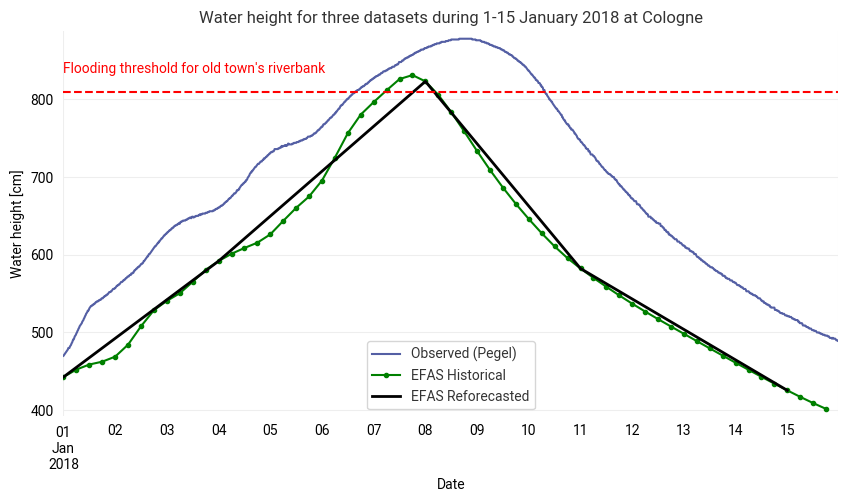

In [81]:
# Pegel
dfW = dfW.copy()
dfW["timestamp"] = pd.to_datetime(dfW["timestamp"])
obs = (dfW[["timestamp","value"]]
       .dropna()
       .sort_values("timestamp")
       .set_index("timestamp"))       # value in cm already
ax = obs.plot(y="value", figsize=(10,5), grid=True, label="Observed (Pegel)")



# Historical
h_ts_cm = (h_from_Q(ts) * 100)
time_index = pd.to_datetime(ts.time.values)

# Build pandas Series
mod = pd.Series(h_ts_cm, index=time_index, name="EFAS_cm").sort_index()
mod = mod.replace([np.inf, -np.inf], np.nan).dropna()
mod.plot(ax=ax, marker=".", color="green",linestyle="-", label="EFAS Historical")



# Reforecasted
ctrl_h_cm = 100 * h_from_Q(ctrl_y)
rfc = pd.Series(ctrl_h_cm, index=pd.to_datetime(x_fixed))
rfc.plot(ax=ax, color="black", lw=2,label="EFAS Reforecasted")



# Horizontal red line at 810 cm
ax.axhline(y=810, color="red", linestyle="--", linewidth=1.5)



# Add text
ax.text(
    x=obs.index.min(),  # place text at the left edge of the plot
    y=810 + 20,          # shift text
    s="Flooding threshold for old town's riverbank",
    color="red",
    fontsize=10,
    va="bottom",         # align text baseline with y position
    ha="left"            # align left edge of text with x
)

ax.set_xlabel("Date")
ax.set_ylabel("Water height [cm]")
ax.set_title("Water height for three datasets during 1-15 January 2018 at Cologne")
ax.legend()
plt.show()

Now we have both some quantities and visualization to make some observations and develop insights about the forecasting performance.

- Whether there will be flooding:

  Since flooding of the old town requires h > 8.1 m, **the reforecasted model maximum of 8.23 m predicted that the old town would be flooded**. However, **the forecast underestimated the absolute maximum by about 0.5 m compared to the observed peak.** This confirms the negative discharge bias of the model we have previously computed. With a little less discharge, the model could have had failed to predict an actual flooding. The historical dataset peaks higher than the reforecasting and also earlier. However, there exist no reforecasting data points for the part where historical dataset overperforms, thus it would be premature to conclude it actually captures the trend better.

- Timing of the flooding:

  The threshold of 8.1 m corresponds to a discharge of about 6715 m³/s. The Pegel surpassed this threshold on 6 January, whereas the reforecast only reached it on 7 January. Thus, **the model predicted flooding of Cologne’s old town one day later than it actually occurred.**

### **Summary and open questions**

The ECMWF model for flood forecasting based on LISFLOSS works extremely successful, given the scale of geography and the various parameters it needs to take into account to calculate this single metric we studied here. We started by studying the true observations which is defined as the measurements from the river gauge in Cologne's old town. The river gauge recorded the flood event wih a clear peak on the 8th of Janury. We have chosen a time interval spanning 1-week before and after this peak. Comparing the observed values to two different datasets provided by the EFAS, we found that there is good correlation but the discharge is underestimated at all times. It was not possible to exactly pinpoint to which parameters cause the discrepancy in this limited study. 

Practical consequences of this discrepancy means an underestimation of water height and shift in the timing of the peak. These could lead to misjudgements about when and how much the old town will be flooded. Thus, there is room for improvement that could affect the real-world outcomes. We also studied various skill parameters used by EFAS to make a comparison. Our skills were lower on all parameters except the correlation. This also shows what EFAS webpage warns its users about: The forecasting skill of hydrological models underperforms during the extreme events. Finally, it should be mentioned that there is disturbing lack of uncertainties in this analysis.

Open questions:
- Relative contribution of temporal shortness vs. extreme nature of analysis period to the observed differences to EFAS estimates:
  
  Although both have contributed to the difference in results, it is possible to study and distinguish these effects. For example one can study a same 2-week period but pick that interval from a season where river activity is similar to the average behavior. This way one can see the limitations of temporal choices when there is no extreme activity present. Another interesting check would be to repeat this study, with changing extending the start and end dates while keeping the 8th January peak at the center of the time interval. This way one can see how gradually including more and more non-extreme tail into the dataset changes the outcomes.
  
- How could the general underestimation bias and forecasting during extreme events can be improved?

  The forecasts are from LISFLOOD tool and it has multiple inputs. Studying the relative contribution of the LISFLOOD inputs for the data points and looking for a pattern for when forecasts are close/away might provide some insights. A cool future project might be to feed the LISFLOOD input parameters into a machine-learning tool and make a regression model to predict the discharge. Since many LISFLOOD input parameters are geographically tagged in the form of grid units, each parameter can be introduced again for each grid unit it is present in, creating a very high number of input parameters. The input set can be reduced by selecting the Rhein river catchment area up to Cologne and excluding other locations. This model could eventually rank the input parameters by importance and point to which parameter from which geographic area (for example the drainage rate of a lake in Switzerland) has the highest impact on the water discharge in Cologne area.

**Please feel free to contact me regarding any questions, corrections or other type of feedback! I appreciate it all. Thanks!**